# Time Series Analysis and Forecasting with ARIMA

### Load the data

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

In [19]:
# Load the data
data = pd.read_csv('Data.csv')
data.head()

,utc_timestamp,IT_load_new,IT_solar_generation
0,2016-01-01T00:00:00Z,21665.0,1
1,2016-01-01T01:00:00Z,20260.0,0
2,2016-01-01T02:00:00Z,19056.0,0
3,2016-01-01T03:00:00Z,18407.0,0
4,2016-01-01T04:00:00Z,18425.0,0


### Visualize the data

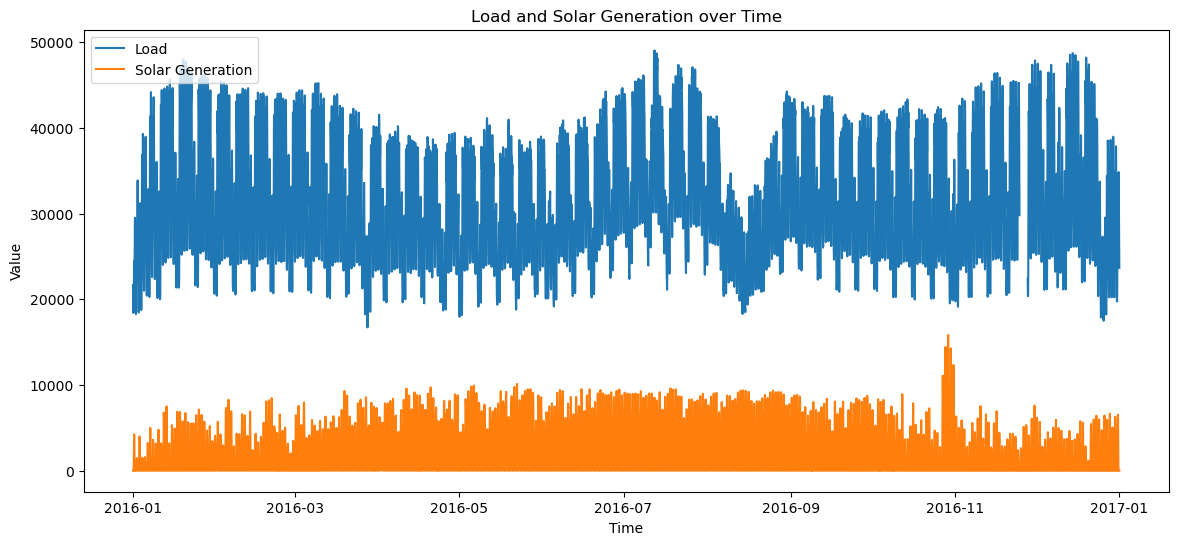

In [20]:
data['utc_timestamp'] = pd.to_datetime(data['utc_timestamp'])
plt.figure(figsize=(14,6))
plt.plot(data['utc_timestamp'], data['IT_load_new'], label='Load')
plt.plot(data['utc_timestamp'], data['IT_solar_generation'], label='Solar Generation')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Load and Solar Generation over Time')
plt.show()

In [21]:
data['utc_timestamp'] = pd.to_datetime(data['utc_timestamp'])
data

,utc_timestamp,IT_load_new,IT_solar_generation
0,2016-01-01 00:00:00+00:00,21665.0,1
1,2016-01-01 01:00:00+00:00,20260.0,0
2,2016-01-01 02:00:00+00:00,19056.0,0
3,2016-01-01 03:00:00+00:00,18407.0,0
4,2016-01-01 04:00:00+00:00,18425.0,0
...,...,...,...
8779,2016-12-31 19:00:00+00:00,31154.0,0
8780,2016-12-31 20:00:00+00:00,28342.0,0
8781,2016-12-31 21:00:00+00:00,26496.0,0
8782,2016-12-31 22:00:00+00:00,25276.0,0


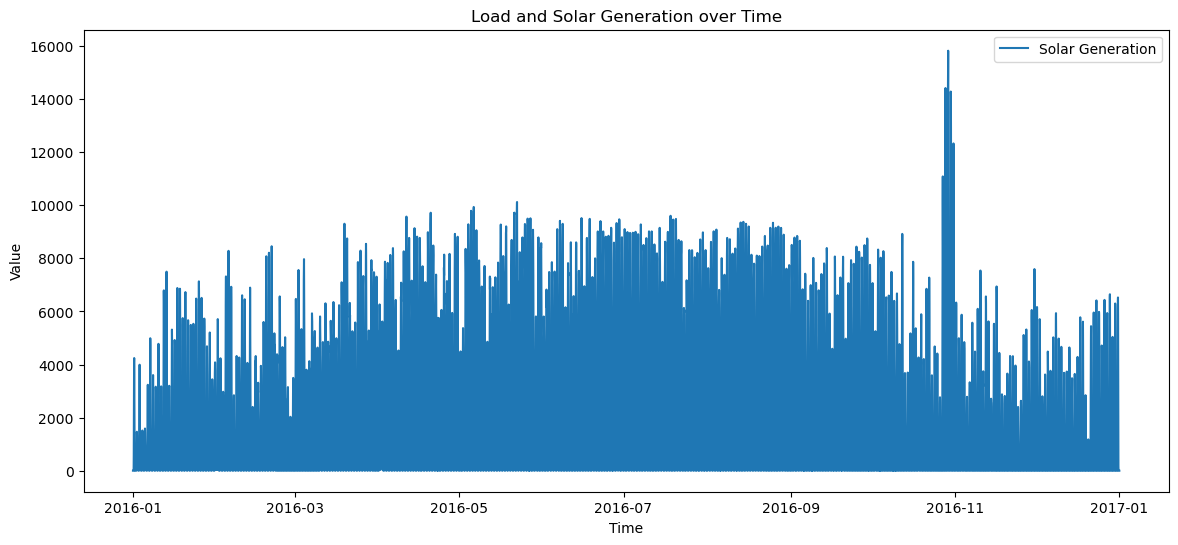

In [22]:
# Plot the data
plt.figure(figsize=(14,6))
plt.plot(data['utc_timestamp'], data['IT_solar_generation'], label='Solar Generation')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Load and Solar Generation over Time')
plt.show()

The load seems to follow a regular pattern, with highs and lows that likely match daily habits of electricity use.
Solar power generation also follows a clear pattern: it only happens during the day and stops at night. The amount of solar energy produced changes throughout the year, probably due to different amounts of sunlight in different seasons.

Before we can use models like ARIMA to predict future values, we need to check if the data is stationary. Stationary data means that its average, variation, and pattern of changes stay consistent over time. ARIMA and many other forecasting methods work best when the data is stationary.

To check this, we can use something called the Augmented Dickey-Fuller (ADF) test.

### Handle missing values

In [23]:
# Check for missing values
data.isnull().sum()

utc_timestamp           0
IT_load_new            72
IT_solar_generation     0
dtype: int64

In [24]:
# Fill missing values using forward fill
data['IT_load_new'].fillna(method='ffill', inplace=True)

# Checking for missing values again
print("Missing values after filling:")
print(data.isnull().sum())

Missing values after filling:
utc_timestamp          0
IT_load_new            0
IT_solar_generation    0
dtype: int64


### Check for stationarity

In [25]:
# Function to perform Augmented Dickey-Fuller test
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [26]:
# Perform Augmented Dickey-Fuller test again
print("\nADF test for 'IT_load_new' after filling missing values:")
adf_test(data['IT_load_new'])

print("\nADF test for 'IT_solar_generation':")
adf_test(data['IT_solar_generation'])


ADF test for 'IT_load_new' after filling missing values:
Results of Dickey-Fuller Test:
Test Statistic                -1.197390e+01
p-value                        3.841445e-22
#Lags Used                     3.700000e+01
Number of Observations Used    8.746000e+03
Critical Value (1%)           -3.431098e+00
Critical Value (5%)           -2.861871e+00
Critical Value (10%)          -2.566946e+00
dtype: float64

ADF test for 'IT_solar_generation':
Results of Dickey-Fuller Test:
Test Statistic                -5.741335e+00
p-value                        6.265438e-07
#Lags Used                     3.600000e+01
Number of Observations Used    8.747000e+03
Critical Value (1%)           -3.431098e+00
Critical Value (5%)           -2.861870e+00
Critical Value (10%)          -2.566946e+00
dtype: float64


In [27]:
# Perform test for 'IT_load_new'
print("ADF test for 'IT_load_new':")
adf_test(data['IT_load_new'])

# Perform test for 'IT_solar_generation'
print("\nADF test for 'IT_solar_generation':")
adf_test(data['IT_solar_generation'])

ADF test for 'IT_load_new':
Results of Dickey-Fuller Test:
Test Statistic                -1.197390e+01
p-value                        3.841445e-22
#Lags Used                     3.700000e+01
Number of Observations Used    8.746000e+03
Critical Value (1%)           -3.431098e+00
Critical Value (5%)           -2.861871e+00
Critical Value (10%)          -2.566946e+00
dtype: float64

ADF test for 'IT_solar_generation':
Results of Dickey-Fuller Test:
Test Statistic                -5.741335e+00
p-value                        6.265438e-07
#Lags Used                     3.600000e+01
Number of Observations Used    8.747000e+03
Critical Value (1%)           -3.431098e+00
Critical Value (5%)           -2.861870e+00
Critical Value (10%)          -2.566946e+00
dtype: float64


### from the Augmented Dickey-Fuller test:

For 'IT_load_new': The p-value is extremely small (much less than 0.05), so we reject the null hypothesis that the time series is non-stationary. Therefore, 'IT_load_new' can be considered stationary.

For 'IT_solar_generation': The p-value is also very small (much less than 0.05), so we reject the null hypothesis. This means 'IT_solar_generation' can be considered stationary as well.

Since both series are stationary, we can proceed with building an ARIMA model for each of them.

ARIMA, which stands for AutoRegressive Integrated Moving Average, is a class of models that explains a given time series based on its own past values, that is, its own lags and the lagged forecast errors. The equation can be used to forecast future values.

Any 'non-seasonal' time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models.

An ARIMA model is characterized by 3 terms: p, d, q

p is the order of the AR term (number of lags of Y to be used as predictors).
q is the order of the MA term (moving average).
d is the number of differencing required to make the time series stationary.
In our case, since the series are already stationary, d=0 for both series. We need to determine the optimal values for p and q. To do this, we'll look at the autocorrelation function (ACF) and partial autocorrelation function (PACF) plots.



### Build ARIMA model for 'IT_load_new'

C:\Users\Prajakta\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


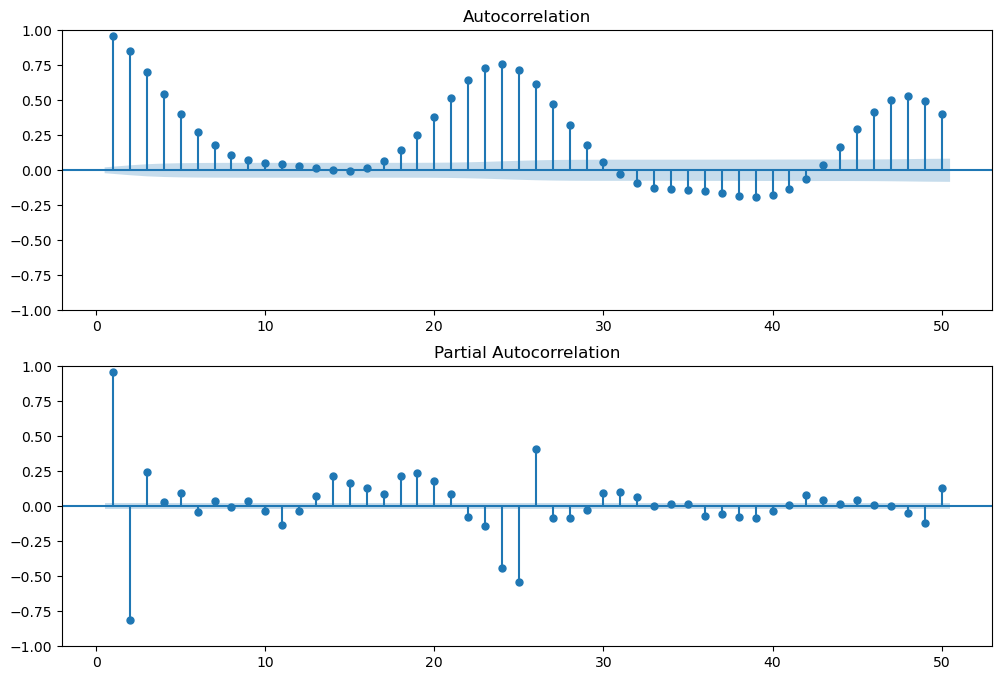

In [28]:
# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
plot_acf(data['IT_load_new'], lags=50, zero=False, ax=ax1)
plot_pacf(data['IT_load_new'], lags=50, zero=False, ax=ax2)
plt.show()

#### From the ACF plot, we see a gradual decrease, and from the PACF plot, there is a sharp drop after lag 2. So we can take p=2 and q=2 as our model parameters.

Now let's fit the ARIMA model to our 'IT_load_new' time series. We will use the first 80% of the data for training and the last 20% for testing. This way, we can evaluate the performance of our model on unseen data.

In [29]:
# Split the data into training and test sets
train_size = int(len(data['IT_load_new']) * 0.8)
train, test = data['IT_load_new'][:train_size], data['IT_load_new'][train_size:]

# Fit the ARIMA model
model = ARIMA(train, order=(2,0,2))
model_fit = model.fit()

# Make predictions on the test set
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test, predictions))
rmse

7714.952134834086

In [30]:
# Fit the ARIMA model
model2 = ARIMA(train, order=(2,1,2))
model_fit2 = model2.fit()

# Make predictions on the test set
predictions2 = model_fit2.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse2 = sqrt(mean_squared_error(test, predictions2))
rmse2

7993.849455116226

In [31]:
# Fit the ARIMA model
model3 = ARIMA(train, order=(2,2,2))
model_fit3 = model2.fit()

# Make predictions on the test set
predictions3 = model_fit3.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse3 = sqrt(mean_squared_error(test, predictions3))
rmse3

7993.849455116226

The root mean squared error (RMSE) for the ARIMA model on 'IT_load_new' is approximately 7715. RMSE is a measure of the differences between the values predicted by a model and the values actually observed. It's a good measure of how accurately the model predicts the response, and it is the most important criterion for fit if the main purpose of the model is prediction.

However, the value of RMSE itself is not as informative as comparing it to some benchmark, like the standard deviation of the response, or comparing between different models for the same dataset. Let's plot the actual values and the forecasted values to visualize how well our model is performing

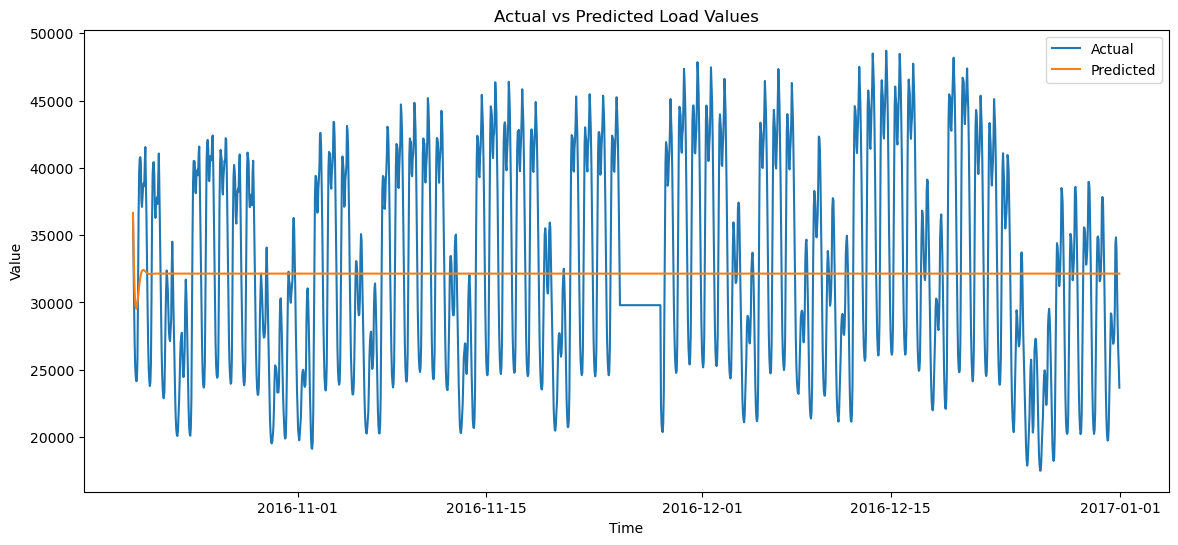

In [32]:
# Plot actual vs predicted values
plt.figure(figsize=(14,6))
plt.plot(data['utc_timestamp'][train_size:], test, label='Actual')
plt.plot(data['utc_timestamp'][train_size:], predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Actual vs Predicted Load Values')
plt.show()

The plot shows the actual versus predicted load values for the test set. While the ARIMA model seems to capture the general pattern and structure of the time series data, there are still some differences between the actual and predicted values.

This discrepancy could be due to various factors such as inherent randomness in the data, the presence of other unaccounted influences, or simply the limitations of the ARIMA model. More complex models or additional data preprocessing might improve the results.

Let's repeat the process for the 'IT_solar_generation' time series. We'll start by plotting the ACF and PACF to determine the parameters for the ARIMA model.

C:\Users\Prajakta\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


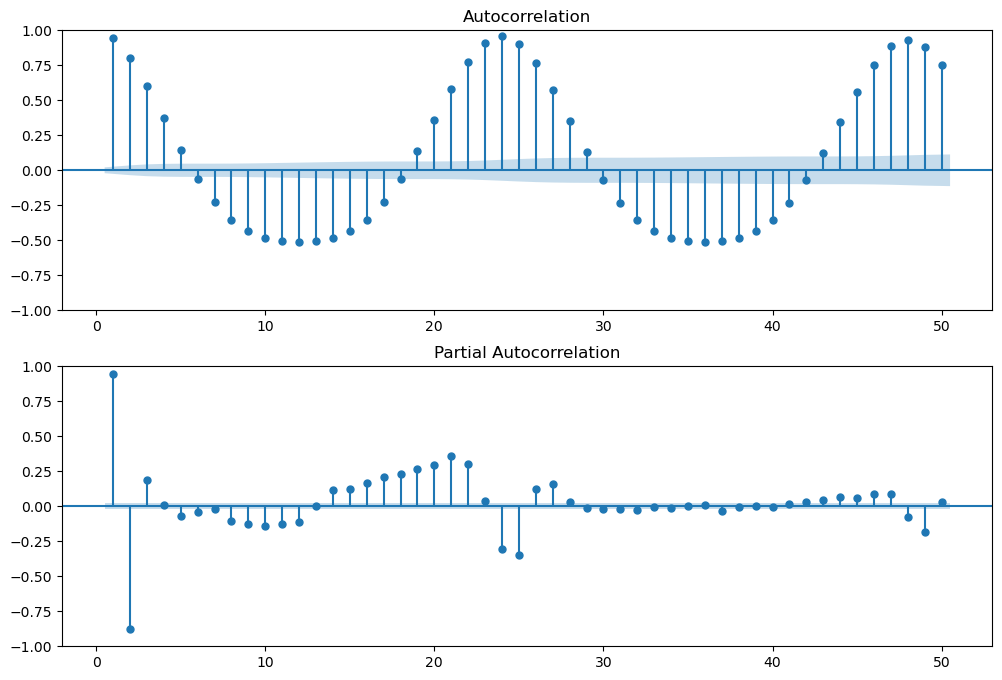

In [33]:
# Plot ACF and PACF for 'IT_solar_generation'
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
plot_acf(data['IT_solar_generation'], lags=50, zero=False, ax=ax1)
plot_pacf(data['IT_solar_generation'], lags=50, zero=False, ax=ax2)
plt.show()

In [34]:
# Split the data into training and test sets
train_size = int(len(data['IT_solar_generation']) * 0.8)
train, test = data['IT_solar_generation'][:train_size], data['IT_solar_generation'][train_size:]

# Fit the ARIMA model
model = ARIMA(train, order=(2,0,2))
model_fit = model.fit()

# Make predictions on the test set
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test, predictions))
rmse

2486.1507110723524

The root mean squared error (RMSE) for the ARIMA model on 'IT_solar_generation' is approximately 2486. As with the 'IT_load_new' model, this RMSE value can be used as a measure of how accurately the model predicts the response.

Again, it's beneficial to plot the actual values and the forecasted values to visualize how well our model is performing.

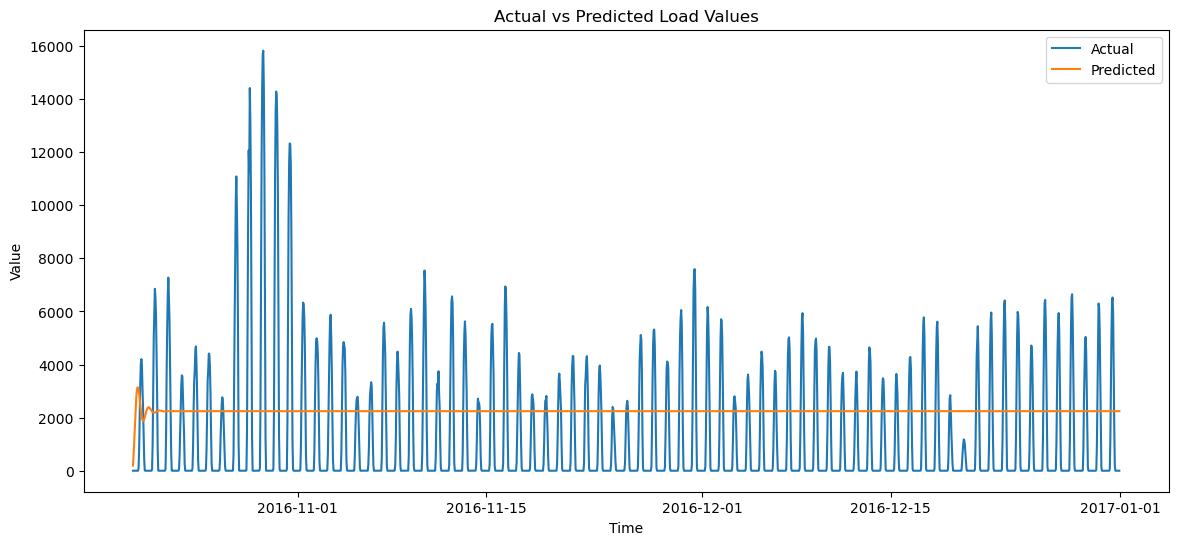

In [35]:
# Plot actual vs predicted values
plt.figure(figsize=(14,6))
plt.plot(data['utc_timestamp'][train_size:], test, label='Actual')
plt.plot(data['utc_timestamp'][train_size:], predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Actual vs Predicted Load Values')
plt.show()

The plot shows the actual versus predicted solar generation values for the test set. As with the load model, the ARIMA model seems to capture the general pattern of the time series data. 